In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 678 kB 8.3 MB/s 


In [255]:
import pyro
import torch
import numpy as np
%matplotlib inline

In [433]:
class SVGD:
    def __init__(self, n_particles, n_dim):
        '''
        :param n_particles: int
        :param n_dim: int
        '''
        self.n_particles = n_particles
        self.particles = torch.randn(self.n_particles, n_dim) * 5

    def step(self, target_distribution_logprob, kernel, learning_rate=0.1):
        '''

        :param target_distribution_logprob: pytorch/pyro callable, return log_prob for each input x
        :param kernel: pytorch callable, need to be able to broadcast for one input
        :param learning_rate: float
        :return: None
        '''

        def dlog():
            particles = self.particles.clone().detach()
            particles.requires_grad_()
            torch.sum(target_distribution_logprob(particles)).backward()  # Because sum is linear
            return particles.grad

        def dkernel(x):
            particles = self.particles.clone().detach()
            particles.requires_grad_()
            torch.sum(kernel(particles, x)).backward()
            return particles.grad

        phi = lambda x: torch.mean(kernel(self.particles, x).reshape(-1, 1) * dlog() + dkernel(x), dim=0)
        phis = torch.stack([phi(self.particles[i, :]) for i in range(self.n_particles)], dim=0)
        self.particles = self.particles + learning_rate * phis

        return self.particles


In [436]:
svgd = SVGD(100, 1)

In [437]:
target_distribution_logprob = lambda x: torch.log(torch.exp(pyro.distributions.Normal(-5, 1).log_prob(x)) * 0.4 +\
                                        torch.exp(pyro.distributions.Normal(5, 2).log_prob(x)) * 0.6)

In [327]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn

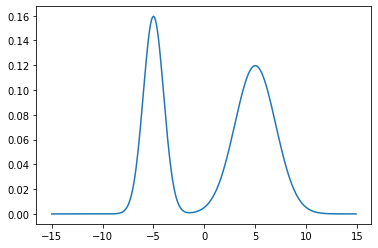

In [328]:
plt.plot(torch.arange(-15, 15, 0.1), torch.exp(target_distribution_logprob(torch.arange(-15, 15, 0.1))))
plt.show()

In [438]:
samples = [svgd.step(target_distribution_logprob, lambda x, y: torch.exp(-(x - y)**2 / 5), 2).flatten().numpy() for i in range(500)]

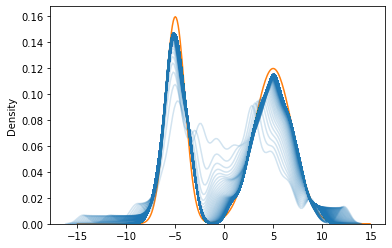

In [439]:
plt.plot(torch.arange(-15, 15, 0.1), torch.exp(target_distribution_logprob(torch.arange(-15, 15, 0.1))), color="tab:orange",)
for i in range(500):
    seaborn.kdeplot(samples[i], alpha=0.2, bw_adjust=0.3, color="tab:blue")

plt.show()

In [440]:
norm_1 = pyro.distributions.MultivariateNormal(torch.tensor([-5, -5]), torch.eye(2)).log_prob
norm_2 = pyro.distributions.MultivariateNormal(torch.tensor([5, 5]), torch.eye(2)*2).log_prob

def target_distribution_logprob(x):
    log_p_1 = norm_1(x)
    log_p_2 = norm_2(x) 

    max_log = torch.max(log_p_1, log_p_2)
    return torch.log(torch.exp(log_p_1 - max_log) * 0.4 + torch.exp(log_p_2 - max_log) * 0.6) + max_log


<a list of 9 text.Text objects>

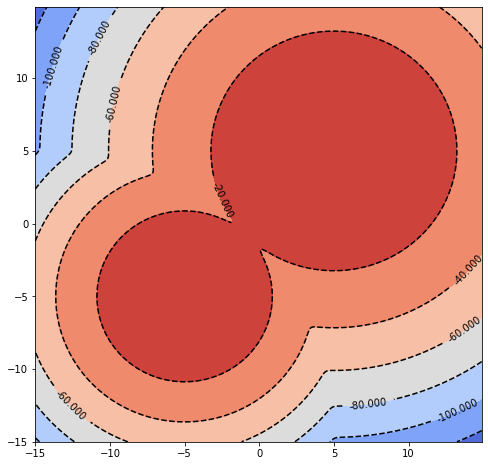

In [385]:

# target_distribution_logprob = lambda x: torch.log(torch.exp(pyro.distributions.MultivariateNormal(torch.tensor([-5, -5]), torch.eye(2)).log_prob(x)) * 0.4 +\
#                                         torch.exp(pyro.distributions.MultivariateNormal(torch.tensor([5, 5]), torch.eye(2)*2).log_prob(x)) * 0.6)
xx, yy = np.mgrid[-15:15:0.1, -15:15:0.1]
ff = np.array([[target_distribution_logprob(torch.tensor([xx[i, j], yy[i, j]]).float()).item() for j in range(300)] for i in range(300)])

fig = plt.figure(figsize=(8,8))
ax = fig.gca()
cfset = ax.contourf(xx, yy, ff, cmap='coolwarm')
cset = ax.contour(xx, yy, ff, colors='k')
ax.clabel(cset, inline=1, fontsize=10)

In [442]:
svgd = SVGD(200, 2)
samples = [svgd.step(target_distribution_logprob, lambda x, y: torch.exp(-torch.sum((x-y)**2, dim=-1) / 5), 2).numpy() for i in range(100)]

(-15.0, 15.0)

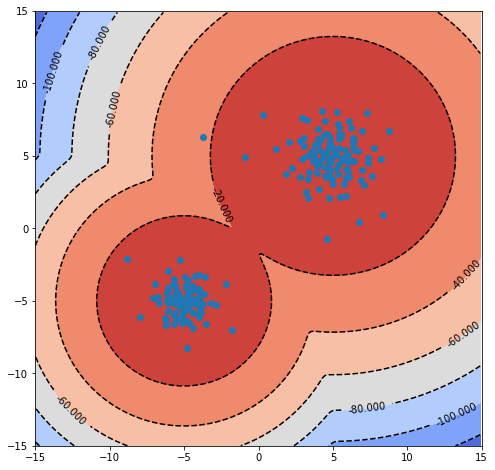

In [443]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
cfset = ax.contourf(xx, yy, ff, cmap='coolwarm')
cset = ax.contour(xx, yy, ff, colors='k')
ax.clabel(cset, inline=1, fontsize=10)


plt.scatter(samples[-1][:, 0], samples[-1][:, 1])
plt.xlim(-15, 15)
plt.ylim(-15, 15)